# 주택 가격 예측: 회귀 문제

## 1. 보스턴 주택 가격 데이터셋

In [1]:
# 보스턴 주택 데이터셋 로드하기
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [2]:
train_data.shape

(404, 13)

In [3]:
test_data.shape

(102, 13)

In [4]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

## 2. 데이터 준비

In [5]:
# 데이터 정규화하기
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

## 3. 모델 구성

In [6]:
# 모델 정의하기
from keras import models
from keras import layers


def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
              input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))

    # mse: mean squared error
    # mae: mean absolute error
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

    return model

## 4. K-겹 검증을 사용한 훈련 검증

In [7]:
# K-겹 검증하기(K-fold cross-validation)
# 이 예제에서는 생략되어 있지만,훈련 데이터의 통계 값으로 테스트 데이터를 전처리했듯이 검증 데이터도 훈련 데이터의 통계 값을 사용하여 전처리해야 한다.
import numpy as np

k = 4

num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('처리중인 폴드 #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)

    model = build_model()
    # verbos=0: 모델 훈련 과정을 출력하지 않음
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

처리중인 폴드 # 0
Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2023-06-03 21:24:07.240003: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [8]:
all_scores

[2.2113068103790283, 3.1956450939178467, 2.615217447280884, 2.541144609451294]

In [9]:
np.mean(all_scores)

2.640828490257263

In [10]:
# 각 폴드에서 검증 점수를 로그에 저장하기
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('처리중인 폴드 #', i)
    val_data = train_data[i * num_val_samples: (i + 1)*num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)

    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets, validation_data=(
        val_data, val_targets), epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [11]:
# K-겹 검증 점수 평균 기록하기
average_mae_history = [np.mean([x[i] for x in all_mae_histories])
                       for i in range(num_epochs)]

# K-겹 검증 점수 평균 기록하기: numpy 사용
average_mae_history = np.mean(all_mae_histories, axis=0)

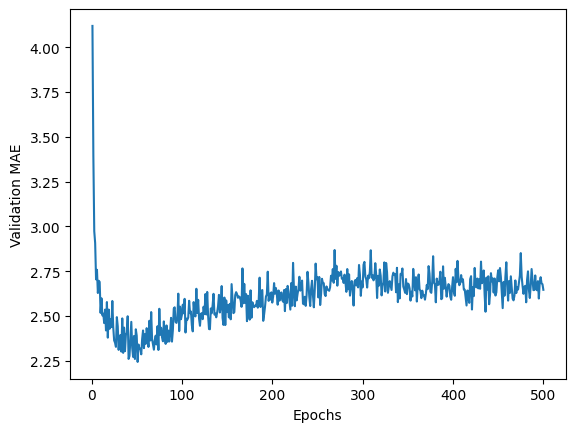

In [12]:
# 검증 점수 그래프
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

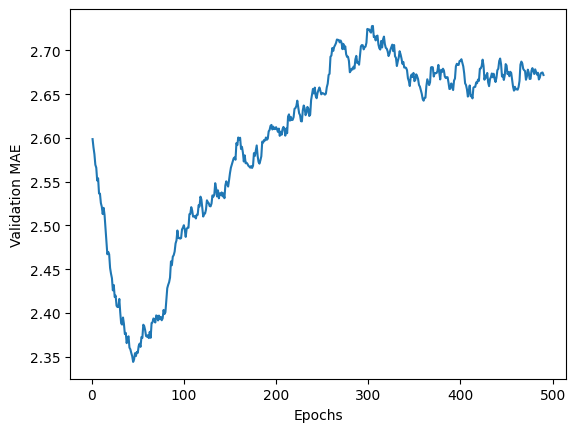

In [13]:
# 처음 10개의 데이터 포인트를 제외한 검증 점수 그리기
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            # 부드러운 곡선을 얻기 위해 각 포인트를 이전 포인트의 지수 이동 평균(exponential moving average)으로 대체함
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points


smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [14]:
# 최종 모델 훈련하기
model = build_model()
model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

test_mae_score

4/4 [==============================] - 0s 15ms/step - loss: 18.2782 - mae: 2.7700


2.770038604736328